## SVI tests



In [1]:
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive
# from numpyro.contrib.funsor import config_enumerate

import matplotlib.pyplot as plt

# from jax.scipy.special import digamma, polygamma, logit, expit, erf

import numpy as np
from numpy.random import default_rng
import pandas as pd
# import seaborn as sns

In [2]:
N = 100
x = np.linspace(-3,3,num=N)
y = .25 + .5 * x + np.random.normal(0., 1., N)

In [3]:
def linmodel(x,y=None):
    alpha = numpyro.sample("alpha", dist.Normal(0,10))
    beta = numpyro.sample("beta", dist.Normal(0,1))
    
    sigma = numpyro.sample("sigma", dist.HalfCauchy(5))

    mu = alpha + beta*x
    
    with numpyro.plate("data", size = x.shape[0]):
        yhat  = numpyro.sample("yhat", dist.Normal(mu, sigma), obs=y)
        return(yhat)
        

In [4]:
kernel = NUTS(linmodel, target_accept_prob=.80)

mcmc = MCMC(kernel, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), x, y)

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1026.44it/s, 3 steps of size 8.59e-01. acc. prob=0.89] 


In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.28      0.11      0.28      0.11      0.46   2107.84      1.00
      beta      0.44      0.06      0.44      0.34      0.54   2962.35      1.00
     sigma      1.07      0.08      1.07      0.95      1.19   2076.41      1.00

Number of divergences: 0


In [6]:
from numpyro.infer.svi import SVI
from numpyro.infer.elbo import Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS
from numpyro.optim import Adam

guide = AutoNormal(linmodel)
optimizer = Adam(1e-3)
loss = Trace_ELBO(num_particles=10)
svi = SVI(linmodel, guide, optimizer, loss)

In [7]:
svi_result = svi.run(random.PRNGKey(0), 5000, x, y)

100%|██████████| 5000/5000 [00:03<00:00, 1440.24it/s, init loss: 4219.0728, avg. loss [4751-5000]: 161.7177]


In [8]:
### for all guides generate samples with sample_posterior()
guide.sample_posterior(random.PRNGKey(0), svi_result.params, (1,))

{'alpha': DeviceArray([0.1822208], dtype=float32),
 'beta': DeviceArray([0.42861402], dtype=float32),
 'sigma': DeviceArray([0.93186814], dtype=float32)}

In [9]:
guide.quantiles(svi_result.params, [.025, .5, .975]) # not all guides have this implemented

{'alpha': DeviceArray([0.12153259, 0.2894356 , 0.45733863], dtype=float32),
 'beta': DeviceArray([0.34476647, 0.46443194, 0.58409745], dtype=float32),
 'sigma': DeviceArray([0.79306746, 0.9024558 , 1.0269321 ], dtype=float32)}

In [64]:
posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=svi_result.params, sample_shape=(1_000,))
# az_data = az.from_dict(
#     {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
# )

pp = Predictive(model = linmodel, posterior_samples = posterior_samples)

In [67]:
pp(random.PRNGKey(1), x)

{'yhat': DeviceArray([[-2.9050345 , -1.1201332 , -1.2055374 , ...,  2.318292  ,
                1.398856  ,  2.4698372 ],
              [-0.8527564 ,  0.05776195, -0.65976065, ...,  1.702352  ,
                1.6136765 ,  1.2553866 ],
              [-1.0644597 , -0.61586404, -1.8153027 , ...,  0.5216195 ,
                1.74001   ,  1.4694233 ],
              ...,
              [ 0.6299159 , -1.9507083 ,  0.46742004, ...,  0.86554086,
                1.0462968 ,  1.3680615 ],
              [ 0.09511375, -1.7649703 , -0.13208367, ...,  2.169853  ,
                1.0713156 ,  1.9779242 ],
              [ 0.75175506, -1.4463072 , -0.73077065, ...,  2.120195  ,
                2.3837774 ,  1.3312551 ]], dtype=float32)}

In [28]:
az_data

Inference data with groups:
	> posterior

In [94]:
import arviz as az

def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000):
    
    posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
    samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
    samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(1), *args)

    return az.from_dict(
        {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
        prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
        posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
        observed_data = {"yhat": obs_data}
    )

azdata = arviz_from_svi(linmodel, guide, svi_result.params, x, obs_data = y)


<AxesSubplot:xlabel='yhat / yhat'>

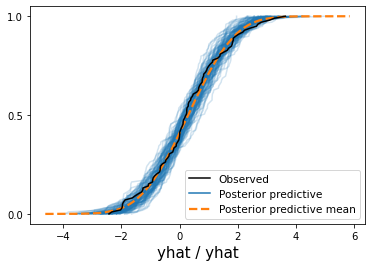

In [75]:
az.plot_ppc(azdata, kind="cumulative", num_pp_samples=100)

The above works!

Below I try with 

### custom guide

this is basically re-implementing the `AutoNormal()`

In [191]:
def linguide(x,y=None):
    a_loc = numpyro.param("a_loc", 0.)
    a_scale = numpyro.param("a_scale", .1, constraint = dist.constraints.positive)
    
    b_loc = numpyro.param("b_loc", 0.)
    b_scale = numpyro.param("b_scale", .1, constraint = dist.constraints.positive)
    
    s_loc = numpyro.param("s_loc", 1.)
    s_scale = numpyro.param("s_scale", 1., constraint = dist.constraints.positive)
    
    alpha = numpyro.sample("alpha", dist.Normal(a_loc, a_scale))
    beta = numpyro.sample("beta", dist.Normal(b_loc, b_scale))
    
    sigma = numpyro.sample("sigma", dist.LogNormal(s_loc, s_scale))

In [192]:
svi = SVI(linmodel, linguide, optimizer, loss)

In [193]:
svi_result = svi.run(random.PRNGKey(0), 5000, x, y)

100%|██████████| 5000/5000 [00:02<00:00, 1683.10it/s, init loss: 193.3090, avg. loss [4751-5000]: 185.1433]


In [194]:
svi_result.params

{'a_loc': DeviceArray(0.35497442, dtype=float32),
 'a_scale': DeviceArray(0.11141248, dtype=float32),
 'b_loc': DeviceArray(0.5155519, dtype=float32),
 'b_scale': DeviceArray(0.08087353, dtype=float32),
 's_loc': DeviceArray(0.37384367, dtype=float32),
 's_scale': DeviceArray(0.49795687, dtype=float32)}

<function __main__.linmodel(x, y=None)>

## Some simulated hierarchical data

In [112]:
## Simulate my own data
n_subjs = 100
n_resps = 200

subjs = np.arange(0,n_subjs)
a_subj = np.random.normal(1, .5, n_subjs)
b_subj = np.random.normal(.5, .25, n_subjs)

subj_idx = np.repeat(subjs, repeats=n_resps)
x = np.random.normal(0, 1, n_resps)
x = np.tile(x, n_subjs)

y = a_subj[subj_idx] + b_subj[subj_idx]*x 
y_obs = np.random.normal(y, .25)

In [113]:
def linmodel_mlm(x, subj, y=None):
    alpha_pop = numpyro.sample("alpha", dist.Normal(0,10))
    beta_pop = numpyro.sample("beta", dist.Normal(0,1))
    
    alpha_sd = numpyro.sample("alpha_sd", dist.HalfCauchy(1))
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))
    
    sigma = numpyro.sample("sigma", dist.HalfCauchy(5))
    
    with numpyro.plate("subj", np.unique(subj).shape[0]):
        alpha_r = numpyro.sample("alpha_r", dist.Normal(0,1))
        beta_r = numpyro.sample("beta_r", dist.Normal(0,1))
        
    alpha = alpha_pop + alpha_r[subj]*alpha_sd
    beta = beta_pop + beta_r[subj]*beta_sd

    mu = alpha + beta*x
    
    with numpyro.plate("data", size = x.shape[0]):
        yhat  = numpyro.sample("yhat", dist.Normal(mu, sigma), obs=y)
        return(yhat)

In [118]:
kernel = NUTS(linmodel_mlm, target_accept_prob=.80)

mcmc = MCMC(kernel, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), x, subj_idx, y_obs)

sample: 100%|██████████| 4000/4000 [00:38<00:00, 104.26it/s, 63 steps of size 4.18e-02. acc. prob=0.91] 


In [104]:
# mcmc.print_summary()

In [121]:
from numpyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoBNAFNormal, AutoMultivariateNormal, AutoIAFNormal
from numpyro.infer import TraceGraph_ELBO, TraceMeanField_ELBO

guide = AutoIAFNormal(linmodel_mlm)
optimizer = Adam(1e-3)
loss = TraceGraph_ELBO(num_particles=10)
svi = SVI(linmodel_mlm, guide, optimizer, loss)

In [122]:
svi_result = svi.run(random.PRNGKey(0), 5_000, x, subj_idx, y_obs)

100%|██████████| 5000/5000 [00:34<00:00, 144.33it/s, init loss: 10469804.0000, avg. loss [4751-5000]: 1471.0516] 


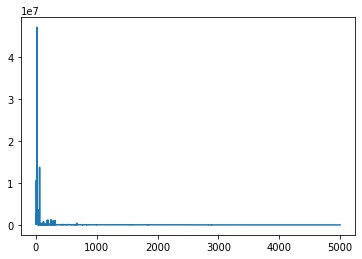

In [126]:
plt.plot(svi_result.losses)
# post_samples = guide.sample_posterior(random.PRNGKey(0), svi_result.params, (1,1000))

In [109]:
az_data_mlm = arviz_from_svi(linmodel_mlm, guide, svi_result.params, x, subj_idx, obs_data=y_obs, num_samples=2_000)

<AxesSubplot:xlabel='yhat / yhat'>

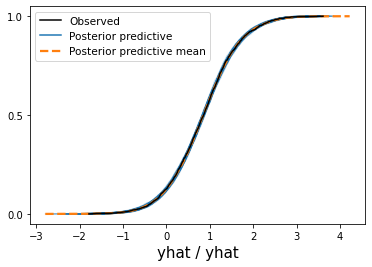

In [110]:
az.plot_ppc(az_data_mlm, kind="cumulative", num_pp_samples=100)

In [117]:
def print_summary_svi(guide, result, prob=.89):
    samples_posterior = guide.sample_posterior(random.PRNGKey(1), params=result.params, sample_shape=(5000,))
    numpyro.diagnostics.print_summary(samples_posterior, prob=prob, group_by_chain=False)
    
print_summary_svi(guide, svi_result)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
      alpha      1.04      0.00      1.04      1.04      1.05   4658.76      1.00
 alpha_r[0]      0.78      0.04      0.78      0.71      0.85   4656.42      1.00
 alpha_r[1]      1.16      0.04      1.16      1.09      1.22   4631.42      1.00
 alpha_r[2]     -0.23      0.04     -0.23     -0.30     -0.16   4602.24      1.00
 alpha_r[3]      0.23      0.04      0.23      0.16      0.29   4949.74      1.00
 alpha_r[4]     -0.04      0.04     -0.04     -0.11      0.02   5400.72      1.00
 alpha_r[5]      0.05      0.04      0.05     -0.02      0.11   4619.50      1.00
 alpha_r[6]     -0.10      0.04     -0.10     -0.17     -0.03   5089.02      1.00
 alpha_r[7]      0.33      0.04      0.33      0.26      0.39   4948.71      1.00
 alpha_r[8]      0.02      0.04      0.01     -0.05      0.08   5002.69      1.00
 alpha_r[9]      1.35      0.04      1.35      1.28      1.41   4756.48      1.00
alpha_r[10]    